In [1]:
import os
import torch

from vismodel import MTSA, ManualAttentionVisualizer, get_tensor, save_heatmap_fig

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
# Configurations

DEFAULT_MODEL_FNAME = './checkpoints/ponswon.pth'
DEFAULT_AUDIO_PATH = '/data/mtat_data'

In [3]:
# Function for visualization
from PIL import Image
from IPython.display import display


def merge_image(image_fnames, new_image):
    images = [Image.open(fname) for fname in image_fnames]
    widths, heights = zip(*(i.size for i in images))
    total_width = max(widths)
    max_height = sum(heights)
    new_im = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in images:
        new_im.paste(im, (0, x_offset))
        x_offset += im.size[1]
    new_im.save(new_image)

    display(new_im)

In [4]:
# Load model

model = MTSA(attention_channels=512, attention_heads=8)
S = torch.load(DEFAULT_MODEL_FNAME)
S = {k.replace('module.', ''): v for k, v in S.items()}
model.load_state_dict(S)
model.cuda()
model.eval()

print('model is loaded!')

model is loaded!


# Attention Heatmap Example

In [5]:
def get_spec_and_attention_heat_map(fn, dump_spec_to, dump_att_to, num_chunks=1, audio_path=DEFAULT_AUDIO_PATH, input_length=256, cmap='coolwarm'):
    x = get_tensor(fn, num_chunks, audio_path, input_length, dump_spec_to=dump_spec_to, cmap=cmap)
    x = x.cuda()
    model(x, fig_base_name=dump_att_to)
    
    return dump_spec_to, dump_att_to + '_2.png'

In [6]:
# Example

os.makedirs('./results', exist_ok=True)
temp_spec_fname = './results/spec_1.png'
temp_att_fname = './results/att_1'
temp_res_fname = './results/merged_1.png'

temp_fn = 'c/jamie_janover-now_center_of_time-07-zeus___bruce_vamp-0-29.mp3'

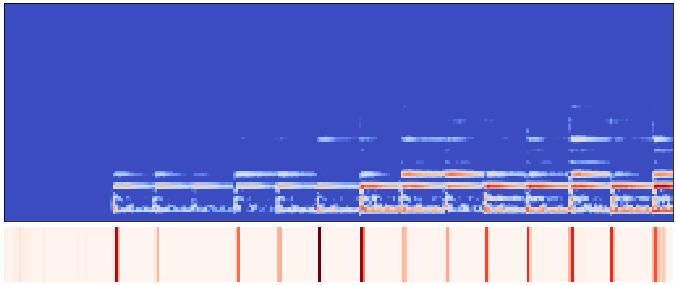

In [7]:
spec_fname, att_fname = get_spec_and_attention_heat_map(temp_fn, temp_spec_fname, temp_att_fname)
merge_image([spec_fname, att_fname], temp_res_fname)

# Tag-wise Contribution Heatmap Example

In [8]:
import librosa.display
import matplotlib.pyplot as plt


def get_specs_and_tagwise_heatmap(fn1, fn2, dump_spec_to, dump_att1_to, dump_att2_to,
                                                           cls1_idx, cls2_idx, layer_idx=2,
                                                           num_chunks=1, audio_path=DEFAULT_AUDIO_PATH, input_length=256, cmap='coolwarm'):
    x1 = get_tensor(fn1, num_chunks, audio_path, input_length, dump_spec_to=None, cmap=cmap)
    x2 = get_tensor(fn2, num_chunks, audio_path, input_length, dump_spec_to=None, cmap=cmap)
    L = int(input_length / 2)

    # For visualization (not for forward)
    spec1 = x1.clone()
    spec2 = x2.clone()
    spec1 = (spec1 - torch.min(spec1)) / (torch.max(spec1) - torch.min(spec1))
    spec2 = (spec2 - torch.min(spec2)) / (torch.max(spec2) - torch.min(spec2))
    spec1[:, :, L:] = spec2[:, :, :L]

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(spec1[0].cpu().detach().numpy(), cmap=cmap)
    plt.savefig(dump_spec_to, bbox_inches='tight', pad_inches=0)
    plt.close()

    # For forward (not for visualization)
    x1[:, :, L:] = x2[:, :, :L]
    x = x1
    x = x.cuda()

    # Compute tag-wise heatmap
    visualizer = ManualAttentionVisualizer(model)
    contrib = visualizer.get_manual_attention(x, layer_idx)
    save_heatmap_fig(contrib[cls1_idx], dump_att1_to)
    save_heatmap_fig(contrib[cls2_idx], dump_att2_to)

    return dump_spec_to, dump_att1_to, dump_att2_to

In [9]:
# Example

os.makedirs('./results', exist_ok=True)
temp_spec_fname = './results/spec_2.png'
temp_res_fname = './results/merged_2.png'

temp_fn1 = 'c/jay_kishor-cd2_the_sowebo_concert-01-raga_malkauns-30-59.mp3'
temp_fn2 = 'c/seismic_anamoly-ramifications-07-serenade_for_samantha-233-262.mp3'

# Index of the tags can be found in https://github.com/keunwoochoi/magnatagatune-list#top-50

# 24 - Quiet
temp_cls1 = 24
# 23 - Loud
temp_cls2 = 23

temp_att1_fname = './results/att_2_{}.png'.format(temp_cls1)
temp_att2_fname = './results/att_2_{}.png'.format(temp_cls2)

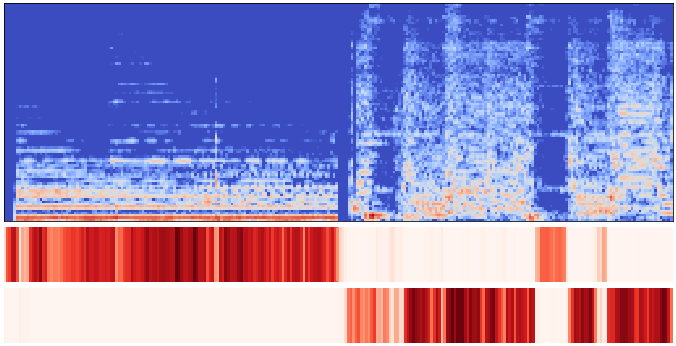

In [10]:
spec_fname, att_fname1, att_fname2 = get_specs_and_tagwise_heatmap(temp_fn1, temp_fn2, temp_spec_fname, temp_att1_fname, temp_att2_fname, temp_cls1, temp_cls2)
merge_image([spec_fname, att_fname1, att_fname2], temp_res_fname)